In [1]:
import tellurium as te
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def convert_bounds_to_logscale(bounds):
    """
    converts bounds for parameters from linear scale to log10 scale. If a bound is 0, it's replaced with 1e-8 to avoid infinity values in log scale.
    Input and output: Ordered dictionaries
    """
    log_bounds = OrderedDict({})

    for param, bound in bounds.items():
        if bound[0] == 0:
            bound = (bound[1]*1e-3, bound[1])
        log_bounds[param] = (np.log10(bound[0]), np.log10(bound[1]))

    return log_bounds

# Testing steady state

In [3]:
import sys
sys.path.append('../Estimation/')
from estimation import set_model_to_ss

In [4]:
model = te.loada('../LCT_model/LCT_OIE.ant')  # ../model/OIE_model.ant

In [5]:
model.M = 0
model.s_BH = 1
res = model.simulate(0, 10000)

In [6]:
res_df = pd.DataFrame(res, columns=res.colnames)

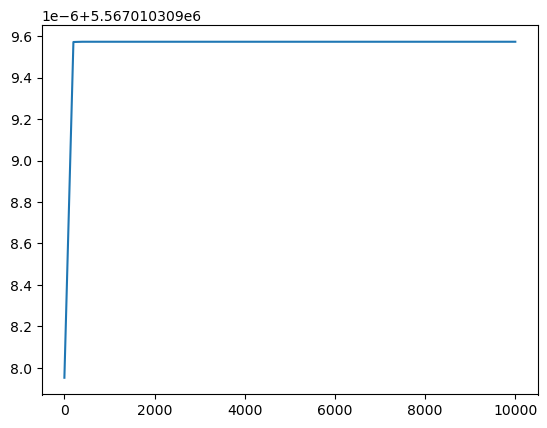

In [7]:
fig, ax = plt.subplots()

ax.plot(res_df['time'], res_df['[E]'])
plt.show()

## Plot R , E over Hkt init

In [8]:
hkt_array = np.arange(0.35, 0.55, 0.05)
model.resetToOrigin()
rs = []
es = []
rpis = []
for hkt in hkt_array:
    model = set_model_to_ss(model, pars={'Hkt_init': hkt})
    rs.append(model.R)
    es.append(model.E)
    rpis.append(model.RPI)
    model.resetToOrigin()


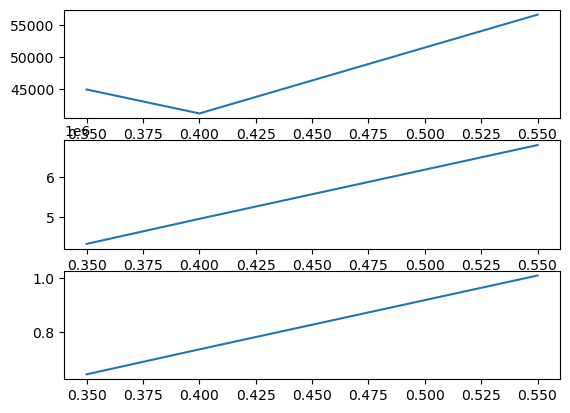

In [9]:
fig, ax = plt.subplots(3, 1)

ax[0].plot(hkt_array, rs)
ax[1].plot(hkt_array, es)
ax[2].plot(hkt_array, rpis)


plt.show()


# Testing infection

In [10]:
def simulate_model(model_path: str = '../LCT_model/LCT_OIE.ant', infection_pars: dict = {}, 
                   ss_duration:float=4.,pre_t:float=3.0, simulation_end:float=50.0,
                   bool_med =True,
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] + [f'[oiE_{i}]' for i in range(1, 13)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    model = te.loada(model_path)

    # ss simulatiom
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    model.M = 40e3

    for p in infection_pars:
        model.setValue(p, infection_pars[p])
    
    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df  

def simulate_model2(model="no", model_path = '../LCT_model/LCT_OIE.ant', 
                   infection_pars: dict = {}, 
                   ss_duration:float=4.,pre_t:float=3.0, simulation_end:float=50.0, 
                   bool_med= True, bool_set_pars=False,
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]','[P]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] + [f'[oiE_{i}]' for i in range(1, 13)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    if type(model)==str:
        model = te.loada(model_path)
   
    if bool_set_pars:
        for p in infection_pars:
            model.setValue(p, infection_pars[p])
        model = set_model_to_ss(model,infection_pars)

    # ss simulation
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    model.M = 1e3

    for p in infection_pars:
        model.setValue(p, infection_pars[p])

    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df  

In [11]:
k_infect = 1.81945778699078967e-06
k_iE_pit_frac = 0.5
# simulate no by-stander haemolysis
infect_pars = {'k_E_infect': k_infect, 's_BH': 0, 'k_iE_pit_frac': k_iE_pit_frac}
no_bh_res = simulate_model(infection_pars=infect_pars, pre_t=3)

# simulate by-stander haemolysis
infect_pars = {'k_E_infect': k_infect, 's_BH': 1.361151210723645e-06,'k_iE_pit_frac': k_iE_pit_frac}#{'k_E_infect': k_infect, 's_BH': 1e-6 }
bh_res = simulate_model(infection_pars=infect_pars, pre_t=3) 

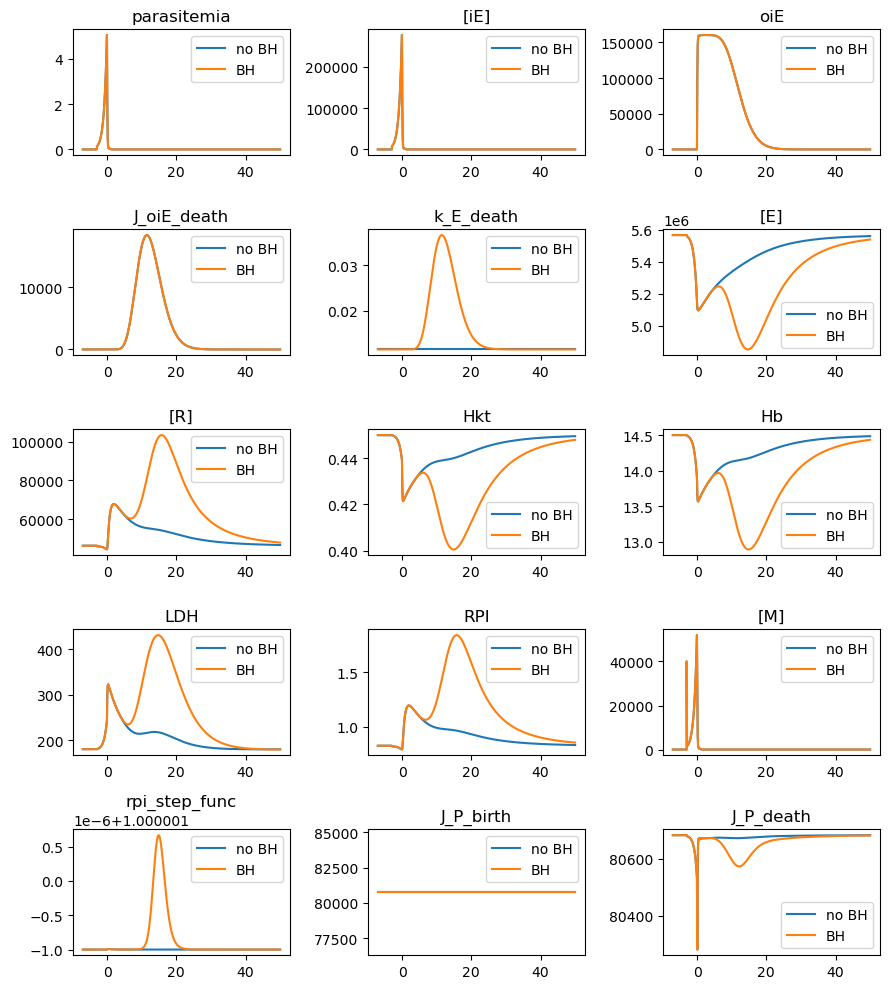

In [12]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[M]','rpi_step_func','J_P_birth', 'J_P_death']

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    ax[row, col].plot(no_bh_res['time'], no_bh_res[obs], label='no BH')
    ax[row, col].plot(bh_res['time'], bh_res[obs], label='BH')
    ax[row, col].set_title(obs)
    ax[row, col].legend()

plt.tight_layout()  
plt.show()

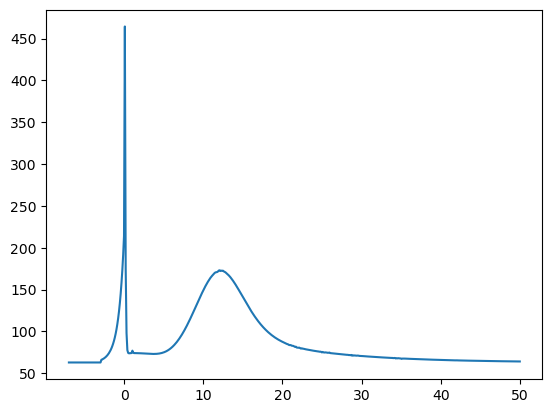

In [13]:
plt.plot(bh_res['time'],bh_res['J_P_birth']-bh_res[obs])

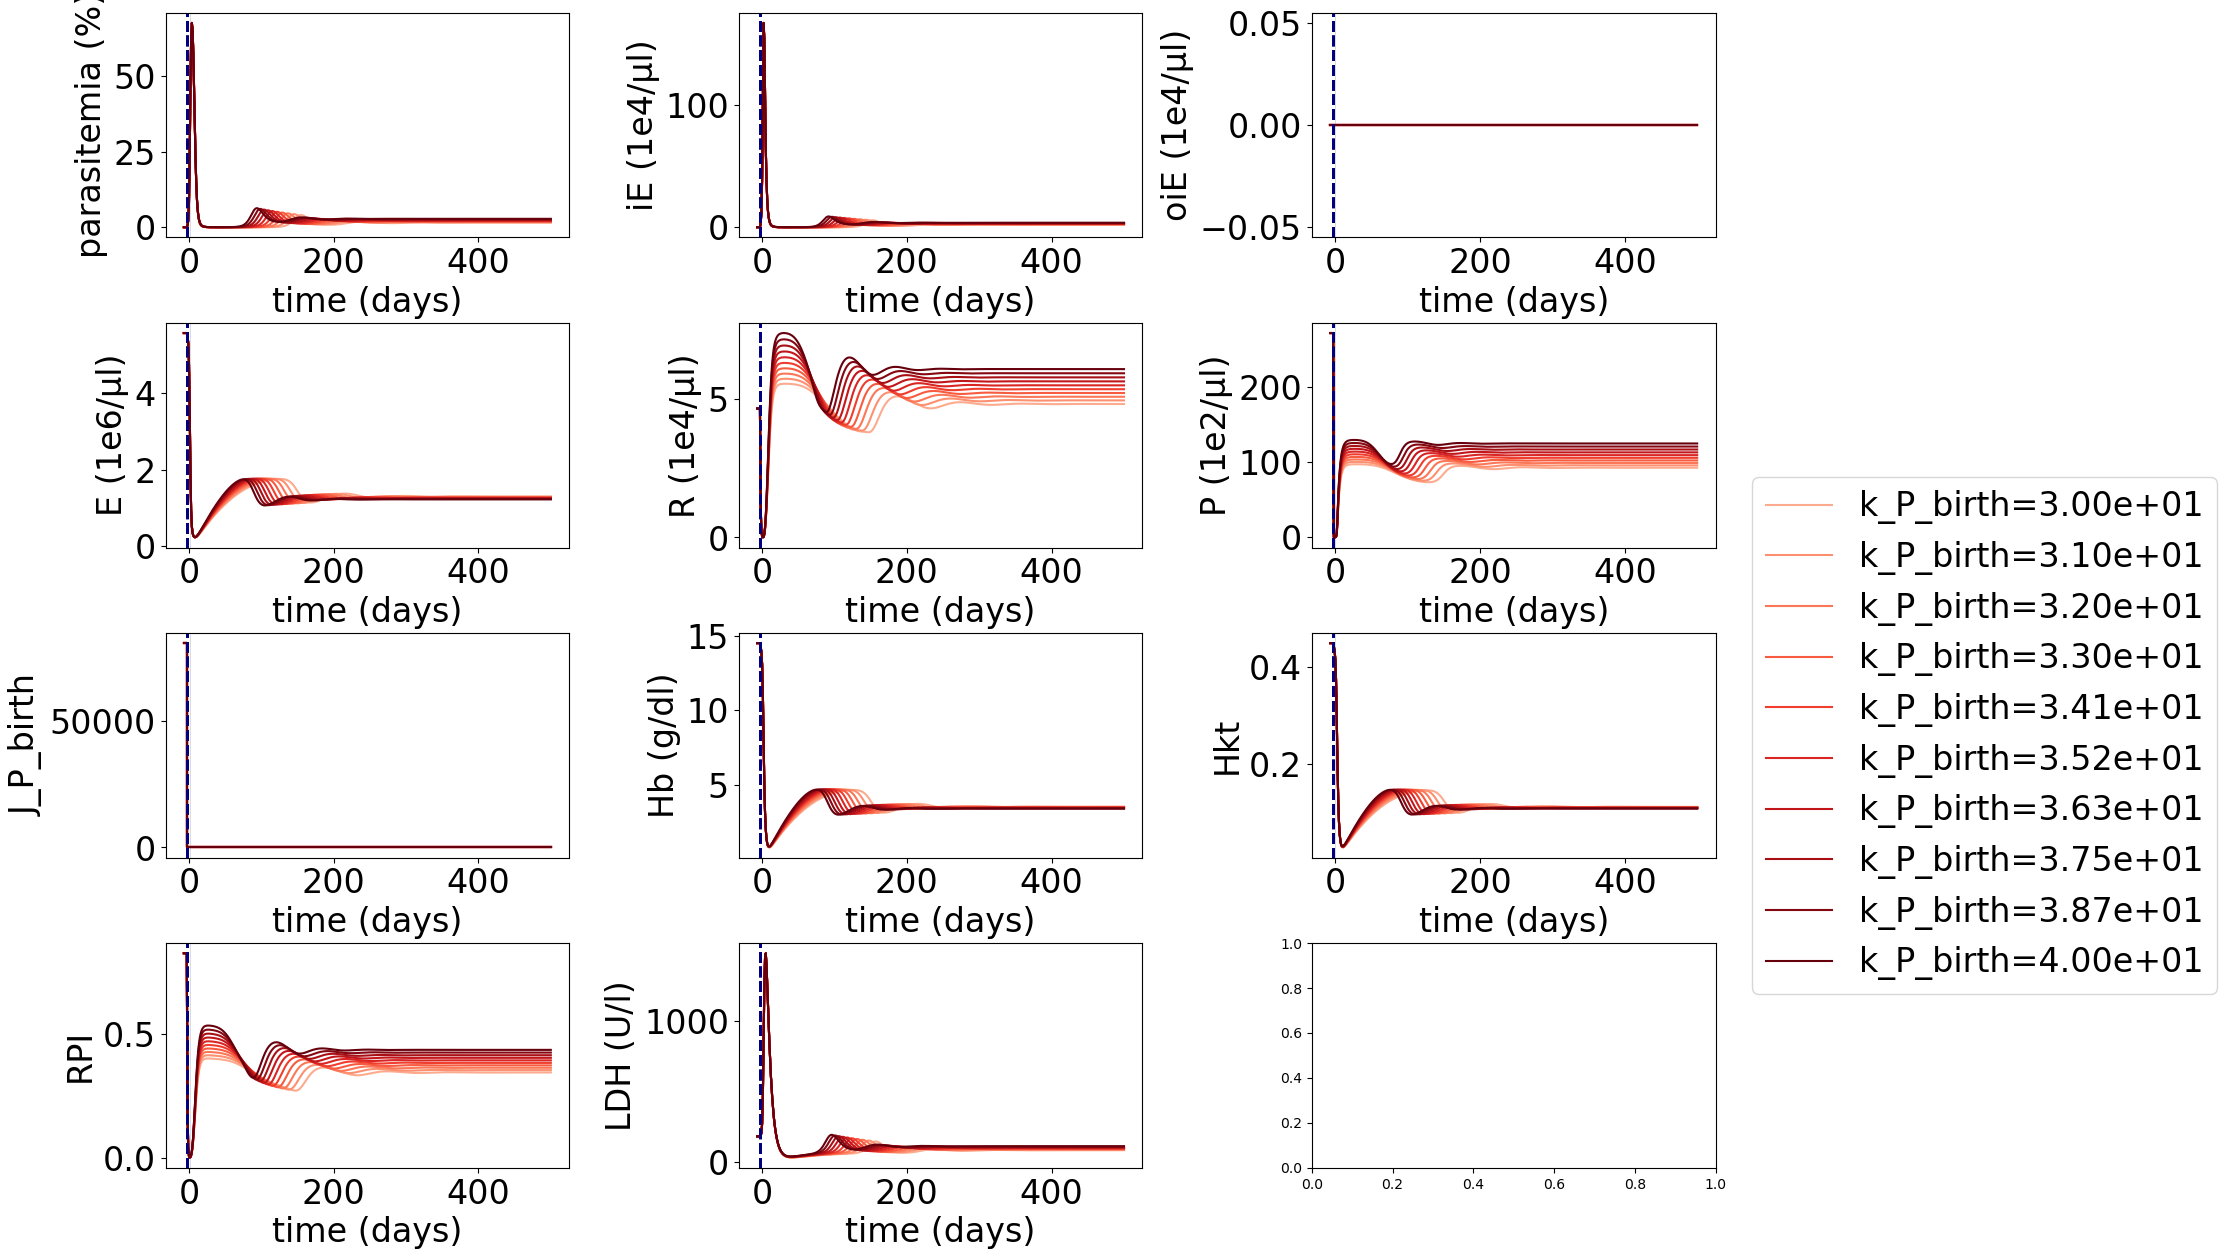

In [14]:
species_to_analyze = OrderedDict({
    'parasitemia' : ['parasitemia (%)', 1],
    '[iE]': ['iE (1e4/µl)', 1e4],
    'oiE': ['oiE (1e4/µl)', 1e4],
    '[E]': ['E (1e6/µl)', 1e6],
    '[R]': ['R (1e4/µl)', 1e4],
    '[P]': ['P (1e2/µl)', 1e0],
    'J_P_birth':['J_P_birth',1e0],
    'Hb': ['Hb (g/dl)', 1],
    'Hkt': ['Hkt', 1],
    'RPI': ['RPI', 1],
    'LDH': ['LDH (U/l)',1],
})
# Possible Reti parameters to manipulate
# k_R_infect
# k_P_birth 295
# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    #'s_BH': (5e-7, 5e-6),
    #'k_E_infect': (5e-7, 2.5e-6),
    'k_P_birth': (3e1, 4e1),
    #'a_P_d':(15000,60600),
    #'k_iE_pit_frac': (0.1,1.1),
})

pre_t = 3
# Konvertiere bounds in logscale
params_bounds_log = convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 10

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):
    # Durchführung des Parameter-Scans und Erstellung der Plots
    cols = 3
    rows = int(np.ceil(len(species_to_analyze)/cols))   

    fig, axs = plt.subplots(rows,cols, figsize=(20,15))
    fig.subplots_adjust(hspace=0.38, wspace= 0.42)
    size_of_font = 24

    for idx, value in enumerate(values):
        result = simulate_model(model_path='../LCT_model/LCT_OIE.ant', infection_pars={param: 10**value}, bool_med=False,
                                pre_t=pre_t,simulation_end=500, selections=['time']+list(species_to_analyze.keys()))	

        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3


            axs[row, col].plot(result['time'], result[specie]/species_to_analyze[specie][1], 
                               label=f'{param}={round(10**value,8):.2e}', 
                               color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            axs[row, col].axvspan(0, 0.3, facecolor='gainsboro', alpha=1, linewidth=2) #, label='ACT Administration')
            axs[row, col].axvspan(1, 1.3, facecolor='gainsboro', alpha=1, linewidth=2)
            axs[row, col].axvspan(2, 2.3, facecolor='gainsboro', alpha=1, linewidth=2)

            axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle='--')   
            
            
        handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-1, -1].legend(handles, labels, loc='lower left', 
                       bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)


#plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    plt.show()

#print(handles, labels)

#plt.savefig("plot.pdf")

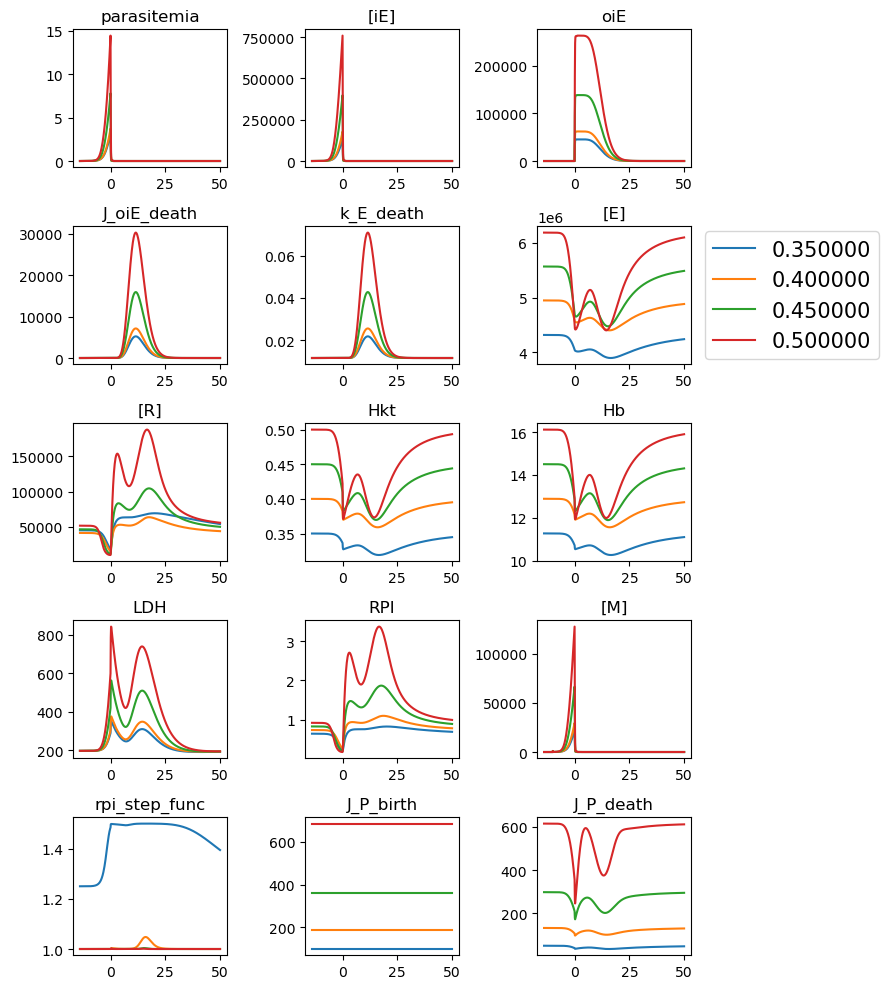

In [15]:
model = te.loada("../LCT_model/LCT_OIE.ant")
pre_t_new = 10
k_E_infect =  1.052041851367283e-06

update_parameters= {
        "k_E_infect": k_E_infect,
        "tropism": 104.429542038768788,
        'k_M_death': 60,
        's_BH': 1.961151210723645e-06,                              # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.010000000517527397,
        "r_P_d": 5.870264855546418,
        "fac_R_d": 0.0,
        "t_E_death":120,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[M]','rpi_step_func','J_P_birth', 'J_P_death']

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for hkt_in in np.arange(0.35,0.5,0.05):
    model.resetToOrigin()
    update_parameters.update({"Hkt_init":hkt_in})
    temp_model = set_model_to_ss(model,update_parameters)
    #print(temp_model.k_P_birth)
    res = simulate_model2(temp_model, infection_pars=infect_pars,pre_t=pre_t_new,
                          bool_set_pars=True,bool_med=True)
    for i, obs in enumerate(observables):
        row = i//n_cols
        col = i%n_cols
        ax[row, col].plot(res['time'], res[obs], label=f"{hkt_in:2f}")
        ax[row, col].set_title(obs)

handles, labels = ax[1, 1].get_legend_handles_labels()  # Legend Box outsides Subplots

ax[1, -1].legend(handles, labels, loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) #bbox (nach rechts-links, oben-unten, negativ yes)

plt.tight_layout()  
plt.show()

In [20]:
pre_t_new = 10
k_E_infect = 1.052041851367283e-06
e_death = 100
tropism = 104
# simulate no by-stander haemolysis
update_parameters= {
        "k_E_infect": k_E_infect,
        "tropism": tropism,
        'k_M_death': 60,
        's_BH': 0,                              # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253,
        "t_E_death":e_death,

}
infect_pars = update_parameters

no_bh_res = simulate_model2(infection_pars=infect_pars,pre_t=pre_t_new, bool_set_pars=True)

# simulate by-stander haemolysis
update_parameters= {
        "k_E_infect": k_E_infect,
        "tropism": tropism,
        'k_M_death': 60,
        's_BH': 1.961151210723645e-06,          # only change here 
        "fac_R_d": 0.0,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253,
        "t_E_death":e_death,

}
infect_pars = update_parameters
bh_res = simulate_model2(infection_pars=infect_pars, pre_t=pre_t_new, bool_set_pars=True) 

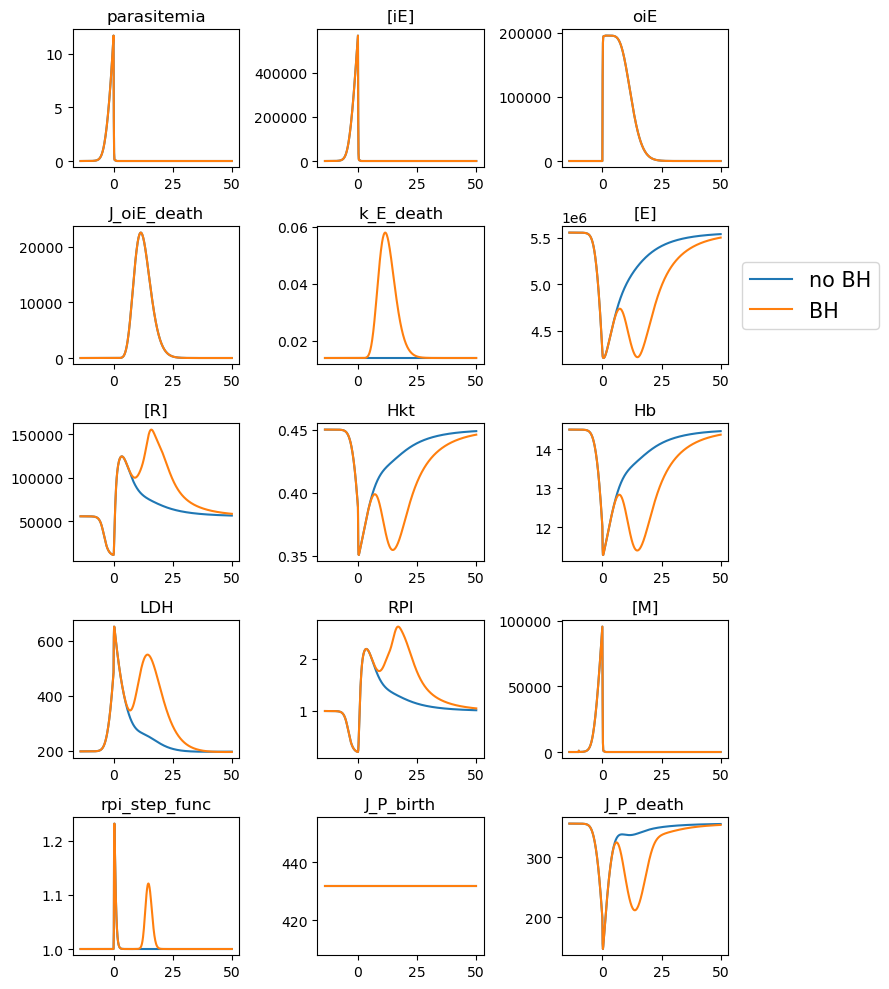

In [21]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[M]','rpi_step_func','J_P_birth', 'J_P_death']

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    ax[row, col].plot(no_bh_res['time'], no_bh_res[obs], label='no BH')
    ax[row, col].plot(bh_res['time'], bh_res[obs], label='BH')
    ax[row, col].set_title(obs)

handles, labels = ax[1, 1].get_legend_handles_labels()  # Legend Box outsides Subplots

ax[1, -1].legend(handles, labels, loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) #bbox (nach rechts-links, oben-unten, negativ yes)

plt.tight_layout()  
plt.show()